# Avaliação de Perfil de Clientes para Aprovação de Empréstimos: Educacional, Médico, Venture (Capital de Risco, investimentos para startups), Empréstimo Pessoal, Quitação de Dívidas e Reforma Residencial
Nesse projeto, será desenvolvido um <b>modelo de machine learning</b> com o objetivo de prever e estipular valores aprovados para cada cliente para Empréstimo. Serão utilizadas técnicas de <b>aprendizado supervisionado</b> com a separação de um dataset para treino e um para teste. Ao final do desenvolvimento do modelo será disponibilizada uma <b>interface gráfica</b> onde o Analista Financeiro, responsável pela simulação, preencherá as informações de cada cliente para serem analisadas.

Utilizarei a seguinte <b>pipeline</b> baseada no <b>CRISP-DM framework:</b>

<b>1. Definição do problema de negócio</b><br>
<b>2. Coletar e ter uma visão inicial dos dados</b><br>
<b>3. Divide os Datasets em treino e teste</b><br>
<b>4. Exploração de dados (EDA: exploratory data analysis)</b><br>
<b>5. Feature engineering, limpeza dos dados e processamento da base</b><br>
<b>6. Treinamento de modelos, comparar, selecionar as melhores features e hiperparâmetros</b><br>
<b>7. Seleção e treinamento do modelo com os melhores resultados</b><br>
<b>8. Conclusão e interpretação dos resultados do modelo final</b><br>
<b>9. Deploy</b><br>

Neste notebook, realizarei as etapas de <b>modelagem e construção dos modelos de machine learning</b>, cobrindo as etapas 1 a 4 do pipeline acima. O principal objetivo aqui é descobrir insights que nos forneçam <b>informações valiosas sobre os padrões dos clientes que solicitam o serviço dentro das características disponíveis</b>. Assim, mesmo antes de construir um modelo, será possível ajudar o banco a identificar perfis e tendências de clientes. Além disso, abordarei essas etapas em detalhes abaixo, explicando o motivo de cada decisão tomada.


# 1. Problema de negócio
- Dificuldade em classificar e determinar as aprovações dos valores de financiamento para cada cliente de acordo com as suas informações.

- O que é experado?
    - Quando um cliente entra na loja...
    - Evitar a análises incorretas ou inquerentes com os princípios do banco
    - Ajudar o Analista Financeiro a agregar sua tomada de decisão...

- Entrega final?

- Quais são os benefícios?

- Interface gráfica ao final do projeto

### Importando bibliotecas e arquivos necessários

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import boto3

from sklearn.model_selection import train_test_split

import const
from utils import *

# Configurações de linhas e colunas
pd.get_option("display.max_rows")
pd.get_option("display.max_columns")

# Exibe gráficos direto no notebook
%matplotlib inline

# Aplica estilo dos gráficos
mpl.style.use('ggplot') 

mpl.rcParams['axes.facecolor'] = 'white'      # Fundo dos gráficos branco
mpl.rcParams['axes.linewidth'] = 1            # Espessura das bordas dos eixos
mpl.rcParams['xtick.color'] = 'black'         # Cor dos ticks do eixo X
mpl.rcParams['ytick.color'] = 'black'         # Cor dos ticks do eixo Y
mpl.rcParams['grid.color'] = 'lightgray'      # Cor da grade (linhas de fundo)
mpl.rcParams['figure.dpi'] = 150              # Resolução das figuras (DPI)
mpl.rcParams['axes.grid'] = True              # Ativa a grade no gráfico
mpl.rcParams['font.size'] = 12                # Tamanho da fonte

# Palette Setting
color_palette = ['#FFD700', '#9400D3', '#FFFF00', '#8A2BE2', '#F0E68C', '#EE82EE']
# Setting as the palette
sns.set_palette(sns.color_palette(color_palette))
# Display
sns.color_palette(color_palette)

[(1.0, 0.8431372549019608, 0.0),
 (0.5803921568627451, 0.0, 0.8274509803921568),
 (1.0, 1.0, 0.0),
 (0.5411764705882353, 0.16862745098039217, 0.8862745098039215),
 (0.9411764705882353, 0.9019607843137255, 0.5490196078431373),
 (0.9333333333333333, 0.5098039215686274, 0.9333333333333333)]

# 2. Visão Inicial dos Dados
- Os dados estão armazenados em um bucket S3, na AWS, criado para a construção do projeto e armazenamento das etapas de tratamento dos dados. Me baseio em 3 principais etapas, sendo elas: 
  - Raw - Armazenando todos os dados brutos.
  - Prata - Armazenando todos os dados trabalhados e divididos, prontos para serem utilizados no treinamento dos modelos.
  - Ouro - Armazenamento dos dados lapidados, pensados e trabalhados para atender demandas espefícidas (Ex: Análises pontuais solicitada pela área de negócio).
- A função <b>fetch_data_from_db()</b> faz a conexão com o bucket e realiza a leitura dos dados.

In [2]:
df = fetch_data_from_db()
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


### Dicionário de dados
1. Age -> Idade
2. Annual Income -> Renda Anual
3. Home ownership -> Propriedade da casa
4. Employment length (in years) -> Tempo de emprego (em anos)
5. Loan intent -> Intenção de empréstimo
6. Loan grade -> Classe do empréstimo
7. Loan amount -> Valor do empréstimo
8. Interest rate -> Taxa de juros
9. Percent income -> Percentual da renda
10. Historical default -> Inadimplência histórica
11. Credit history length -> Comprimento do histórico de crédito
</br>
<b>Target:</b> Loan status (0 is non default 1 is default) -> Status do empréstimo (0 é não inadimplente, 1 é inadimplente)

In [3]:
df.rename(columns={
    'person_age': 'idade',
    'person_income': 'renda_anual',
    'person_home_ownership': 'tipo_residencia',
    'person_emp_length': 'tempo_emprego',
    'loan_intent': 'objetivo_emprestimo',
    'loan_grade': 'cd_objetivo_emprestimo',
    'loan_amnt': 'valor_emprestimo',
    'loan_int_rate': 'taxa_juros',
    'loan_status': 'estatus_inadimplencia',
    'loan_percent_income': 'percentural_renda_consumido',
    'cb_person_default_on_file': 'historico_inadimplencia',
    'cb_person_cred_hist_length': 'anos_de_credito'
}, inplace=True)

# To-dos

- analizar historico de inadimplencia com inadimplencia atual
- analizar percentual de consumo do emprestimo na renda com o status de inadimplencia atual
- valores de emprestimos que consomem acima de 50% da renda tem maior inadimplencia?
- pessoas com inadimplencia histórica tem maior inadimplencia atual?
- o objetivo do emprestimo representa alguma relevancia com a inadimplencia?
- relação de todas as variáveis com a estatus_inadimplencia

In [5]:
df.shape

(32581, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   idade                        32581 non-null  int64  
 1   renda_anual                  32581 non-null  int64  
 2   tipo_residencia              32581 non-null  object 
 3   tempo_emprego                31686 non-null  float64
 4   objetivo_emprestimo          32581 non-null  object 
 5   cd_objetivo_emprestimo       32581 non-null  object 
 6   valor_emprestimo             32581 non-null  int64  
 7   taxa_juros                   29465 non-null  float64
 8   estatus_inadimplencia        32581 non-null  int64  
 9   percentural_renda_consumido  32581 non-null  float64
 10  historico_inadimplencia      32581 non-null  object 
 11  anos_de_credito              32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


### Limpeza e tratamento de dados

In [7]:
df.isnull().sum()

idade                             0
renda_anual                       0
tipo_residencia                   0
tempo_emprego                   895
objetivo_emprestimo               0
cd_objetivo_emprestimo            0
valor_emprestimo                  0
taxa_juros                     3116
estatus_inadimplencia             0
percentural_renda_consumido       0
historico_inadimplencia           0
anos_de_credito                   0
dtype: int64

In [8]:
df[df['tempo_emprego'].isnull()]

,idade,renda_anual,tipo_residencia,tempo_emprego,objetivo_emprestimo,cd_objetivo_emprestimo,valor_emprestimo,taxa_juros,estatus_inadimplencia,percentural_renda_consumido,historico_inadimplencia,anos_de_credito
105,22,12600,MORTGAGE,NaN,PERSONAL,A,2000,5.42,1,0.16,N,4
222,24,185000,MORTGAGE,NaN,EDUCATION,B,35000,12.42,0,0.19,N,2
379,24,16800,MORTGAGE,NaN,DEBTCONSOLIDATION,A,3900,NaN,1,0.23,N,3
407,25,52000,RENT,NaN,PERSONAL,B,24000,10.74,1,0.46,N,2
408,22,17352,MORTGAGE,NaN,EDUCATION,C,2250,15.27,0,0.13,Y,3
...,...,...,...,...,...,...,...,...,...,...,...,...
32285,38,12000,OWN,NaN,EDUCATION,A,4800,7.29,1,0.40,N,12
32328,51,18408,RENT,NaN,PERSONAL,C,1000,14.65,1,0.05,Y,20
32360,70,39996,RENT,NaN,MEDICAL,C,3600,15.23,0,0.09,Y,19
32453,56,32400,RENT,NaN,MEDICAL,A,8575,7.51,0,0.26,N,18


In [9]:
df[df['taxa_juros'].isnull()]

,idade,renda_anual,tipo_residencia,tempo_emprego,objetivo_emprestimo,cd_objetivo_emprestimo,valor_emprestimo,taxa_juros,estatus_inadimplencia,percentural_renda_consumido,historico_inadimplencia,anos_de_credito
39,23,71500,RENT,3.0,DEBTCONSOLIDATION,D,30000,NaN,1,0.42,N,4
50,24,78000,RENT,4.0,DEBTCONSOLIDATION,D,30000,NaN,1,0.38,Y,4
57,23,277000,OWN,3.0,PERSONAL,A,35000,NaN,0,0.13,N,4
59,24,12000,OWN,2.0,VENTURE,E,1750,NaN,0,0.15,Y,3
62,26,263000,MORTGAGE,0.0,EDUCATION,B,10000,NaN,1,0.04,N,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32547,53,4888,OWN,0.0,VENTURE,C,1400,NaN,1,0.29,Y,28
32552,65,45900,RENT,2.0,EDUCATION,C,10000,NaN,0,0.22,Y,19
32553,54,20000,RENT,2.0,MEDICAL,C,5000,NaN,0,0.25,N,28
32569,51,60000,MORTGAGE,1.0,PERSONAL,A,7500,NaN,0,0.13,N,23


### Tratamento de valores nulos
- Na Coluna **tempo_emprego** existem **895 registors nulos**, analisando os registros correspondentes e em contato com a área de negócio, foi observada a possibilidade do tempo de carreira ser menor que 1 ano e por isso **os nulos serão substituídos por 0**

- Na coluna **taxa_juros** foram encontrados registros válidos, em contato com a área responsável pelas informações de juros, **foi detectado um erro de cadastro**. **Os valores serão exclídos da base**.

In [10]:
# Excluir valores onde a coluna taxa_juros estiver zerada
df_filtrado = df[df['taxa_juros'].notna()]

In [11]:
# Substituir por 0 na coluna tempo_emprego
df_filtrado = df_filtrado.fillna(0)

In [12]:
df_filtrado.shape

(29465, 12)

In [13]:
df_filtrado.isnull().sum()

idade                          0
renda_anual                    0
tipo_residencia                0
tempo_emprego                  0
objetivo_emprestimo            0
cd_objetivo_emprestimo         0
valor_emprestimo               0
taxa_juros                     0
estatus_inadimplencia          0
percentural_renda_consumido    0
historico_inadimplencia        0
anos_de_credito                0
dtype: int64

In [14]:
df_filtrado[df_filtrado.duplicated()]

,idade,renda_anual,tipo_residencia,tempo_emprego,objetivo_emprestimo,cd_objetivo_emprestimo,valor_emprestimo,taxa_juros,estatus_inadimplencia,percentural_renda_consumido,historico_inadimplencia,anos_de_credito
15975,23,42000,RENT,5.0,VENTURE,B,6000,9.99,0,0.14,N,4
15989,23,90000,MORTGAGE,7.0,EDUCATION,B,8000,10.36,0,0.09,N,3
15995,24,48000,MORTGAGE,4.0,MEDICAL,A,4000,5.42,0,0.08,N,4
16025,24,10000,RENT,8.0,PERSONAL,A,3000,7.90,1,0.30,N,3
16028,23,100000,MORTGAGE,7.0,EDUCATION,A,15000,7.88,0,0.15,N,4
...,...,...,...,...,...,...,...,...,...,...,...,...
31947,40,38000,RENT,4.0,DEBTCONSOLIDATION,D,7000,15.99,1,0.18,N,16
32010,42,39996,MORTGAGE,2.0,HOMEIMPROVEMENT,A,2500,5.42,0,0.06,N,12
32047,36,250000,RENT,2.0,DEBTCONSOLIDATION,A,20000,7.88,0,0.08,N,17
32172,49,120000,MORTGAGE,12.0,MEDICAL,B,12000,10.99,0,0.10,N,12


### Dados duplicados
- Através da extração e análise dos dados que foram categorizados como duplicados, foi-se entendido que, por possuirem valores parecidos, foram agrupados dessa forma. Porém não são registros duplicados, por este motivo seguirão na base.

In [16]:
df_limpo = df_filtrado

In [17]:
df_limpo.columns = [x.lower() for x in df.columns]

In [18]:
df_limpo.rename(columns={'historico_inadimplencia': 'target'}, inplace=True)

In [21]:
df_limpo.describe().T

,count,mean,std,min,25%,50%,75%,max
idade,29465.0,27.714712,6.300193,20.00,23.00,26.00,30.00,144.00
renda_anual,29465.0,66020.470490,61901.422932,4000.00,38500.00,55000.00,79100.00,6000000.00
tempo_emprego,29465.0,4.654268,4.171572,0.00,2.00,4.00,7.00,123.00
valor_emprestimo,29465.0,9584.744612,6316.272282,500.00,5000.00,8000.00,12250.00,35000.00
taxa_juros,29465.0,11.011695,3.240459,5.42,7.90,10.99,13.47,23.22
estatus_inadimplencia,29465.0,0.219379,0.413833,0.00,0.00,0.00,0.00,1.00
percentural_renda_consumido,29465.0,0.170110,0.106879,0.00,0.09,0.15,0.23,0.83
anos_de_credito,29465.0,5.788257,4.031987,2.00,3.00,4.00,8.00,30.00


In [45]:
df_limpo[df_limpo['idade'] == 144.00]

,idade,renda_anual,tipo_residencia,tempo_emprego,objetivo_emprestimo,cd_objetivo_emprestimo,valor_emprestimo,taxa_juros,estatus_inadimplencia,percentural_renda_consumido,target,anos_de_credito
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0,0.02,N,3
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,0,0.03,N,2
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0,0.00,N,25


In [22]:
df_limpo[df_limpo['tempo_emprego'] == 123]

,idade,renda_anual,tipo_residencia,tempo_emprego,objetivo_emprestimo,cd_objetivo_emprestimo,valor_emprestimo,taxa_juros,estatus_inadimplencia,percentural_renda_consumido,target,anos_de_credito
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0,0.10,N,4


- Identificado valor de **144**, que representa um valor discrepante na base, na coluna **idade**.
- Inclusive o registro será reportado ao time de Segurança e Fraude.
- Identificados os valores de **123** na coluna **tempo_emprego**, conforme alinhado com o time de Cadastro foi um erro no registro, os mesmos serão excluídos da base.
##### Tratativa: exclusão dos valores na base

### Insights Observados

#### 1. **person_age** (Idade)
- **Valor máximo**: 144 anos  
- **Problema**: Possível **outlier** (idade biologicamente inviável).  
- **Ação sugerida**: Remover registros inconsistentes.

#### 2. **person_income** (Renda Anual)
- **Média**: ~$66.654
- **Desvio padrão alto**: Diferença extrema entre média e valores máximos.  
- **Problema**:  
  - **Outliers** evidentes.  
  - **Suspeita de fraude** em valores extremos.  
- **Ação sugerida**: Excluir registros com renda acima do valor definido pela área de negócio ($500.000).

#### 3. **tempo_emprego** (Tempo no Emprego)
- **Valor máximo**: 123 anos  
- **Problema**: **Outlier** (improvável tempo de emprego maior que a idade).  
- **Causa provável**: Erro de digitação.  
- **Ação sugerida**:  Remover registros inconsistentes.

#### 4. **target** (Inadimplência)
- **Valores**: 0 (quitado) e 1 (inadimplente).  
- **Média**: 0.217 → **21.7%** de inadimplência.  
- **Importância**: Métrica central para avaliar a eficácia do modelo.  

#### 5. **Relação Renda/Valor do Empréstimo**
- **Média**: Empréstimos comprometem ~17% da renda anual.  
- **Oportunidade**:  
  - **Feature engineering**: Criar coluna `%_renda_comprometida`.  
  - **Regra de decisão**: Sinalizar empréstimos que excedam 17% da renda (potencial risco).  

#### **Próximos Passos Recomendados**
1. **Tratamento de outliers**:  
   - Definir limites realistas para idade, renda e tempo de emprego.  
   - Remover/excluir registros fora desses limites.  
2. **Feature engineering**:  
   - Criar variável `%_renda_comprometida`.  
3. **Balanceamento de dados**:  
   - Verificar se a classe `target` (21.7% inadimplentes) requer técnicas como SMOTE ou undersampling.  

### Análises para tratamento de Outliers

Outlier identificados: 
- idade
- renda_anual
- tempo_emprego

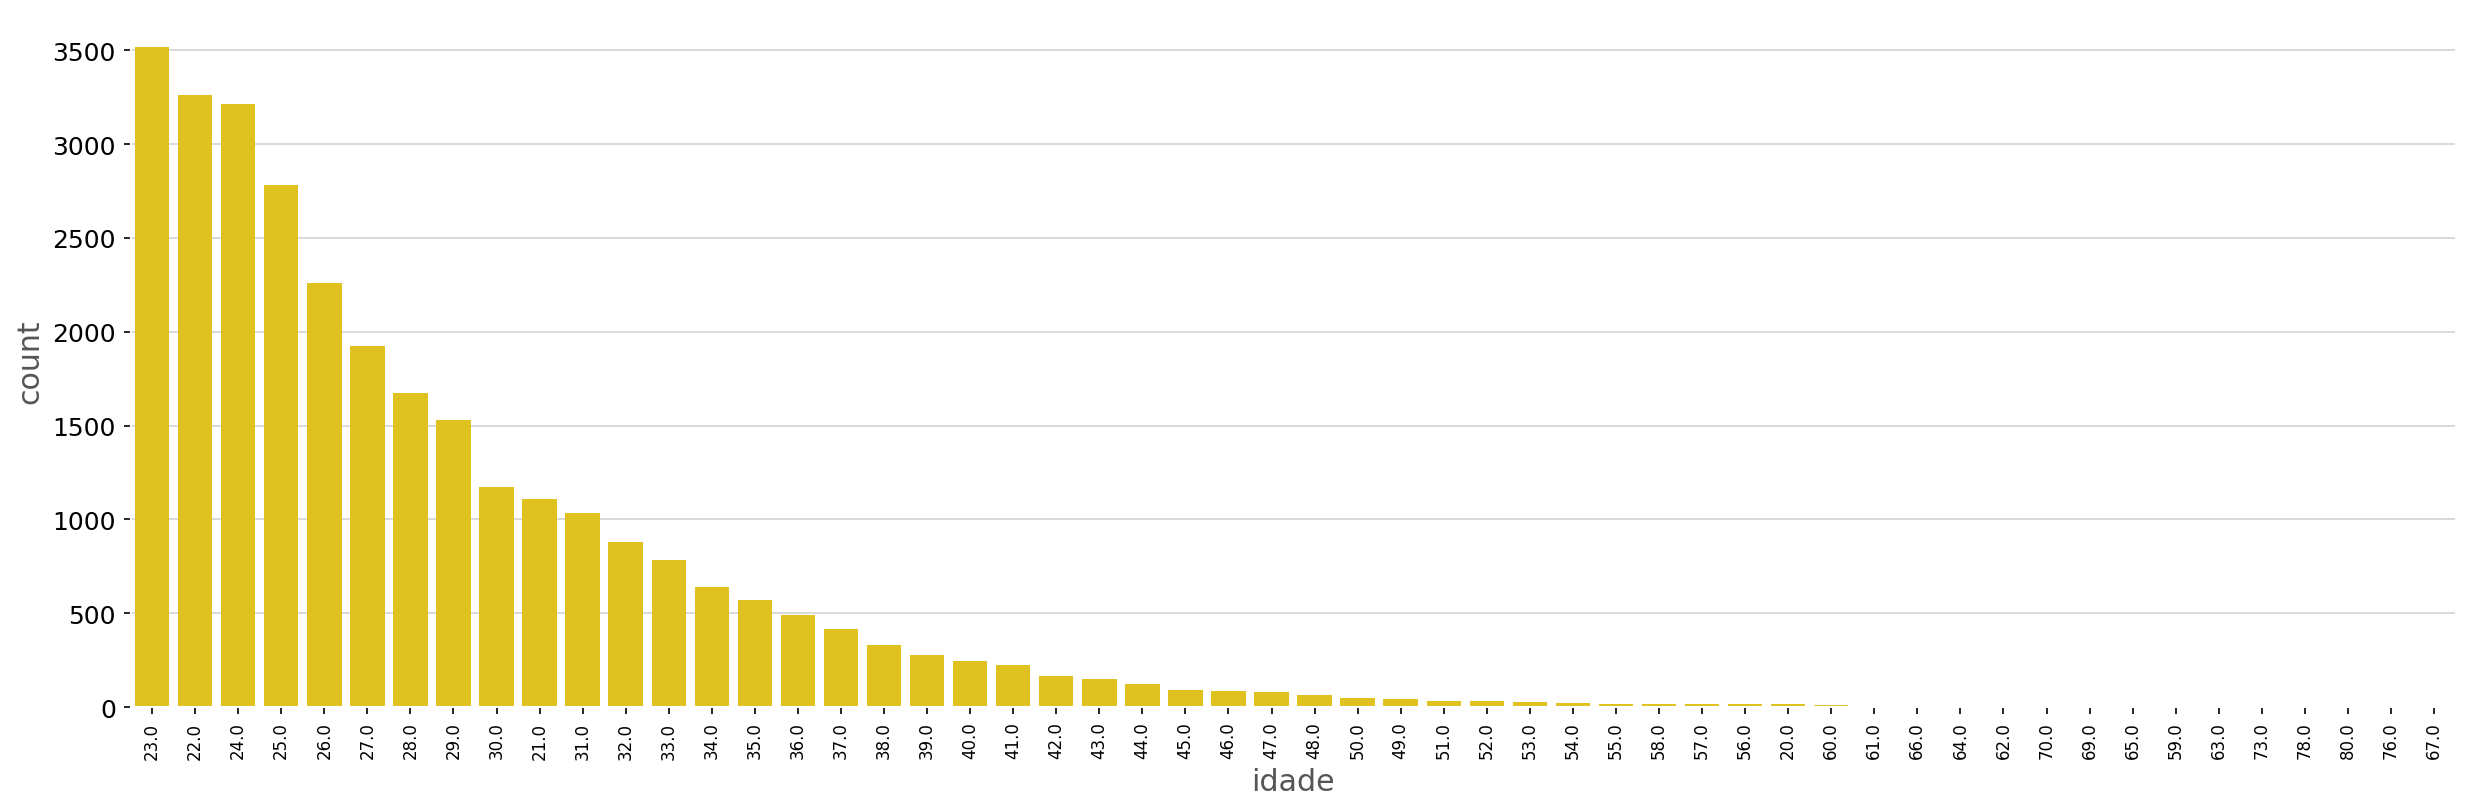

In [37]:
plt.figure(figsize=(20, 6))
sns.countplot(
    data=df_limpo,
    x="idade",
    order=df_limpo["idade"].value_counts().index
)
plt.xticks(rotation=90, fontsize=8)
plt.show()

In [ ]:
sns.boxplot(x="renda", y="renda", data=df_limpo)

KeyboardInterrupt: 

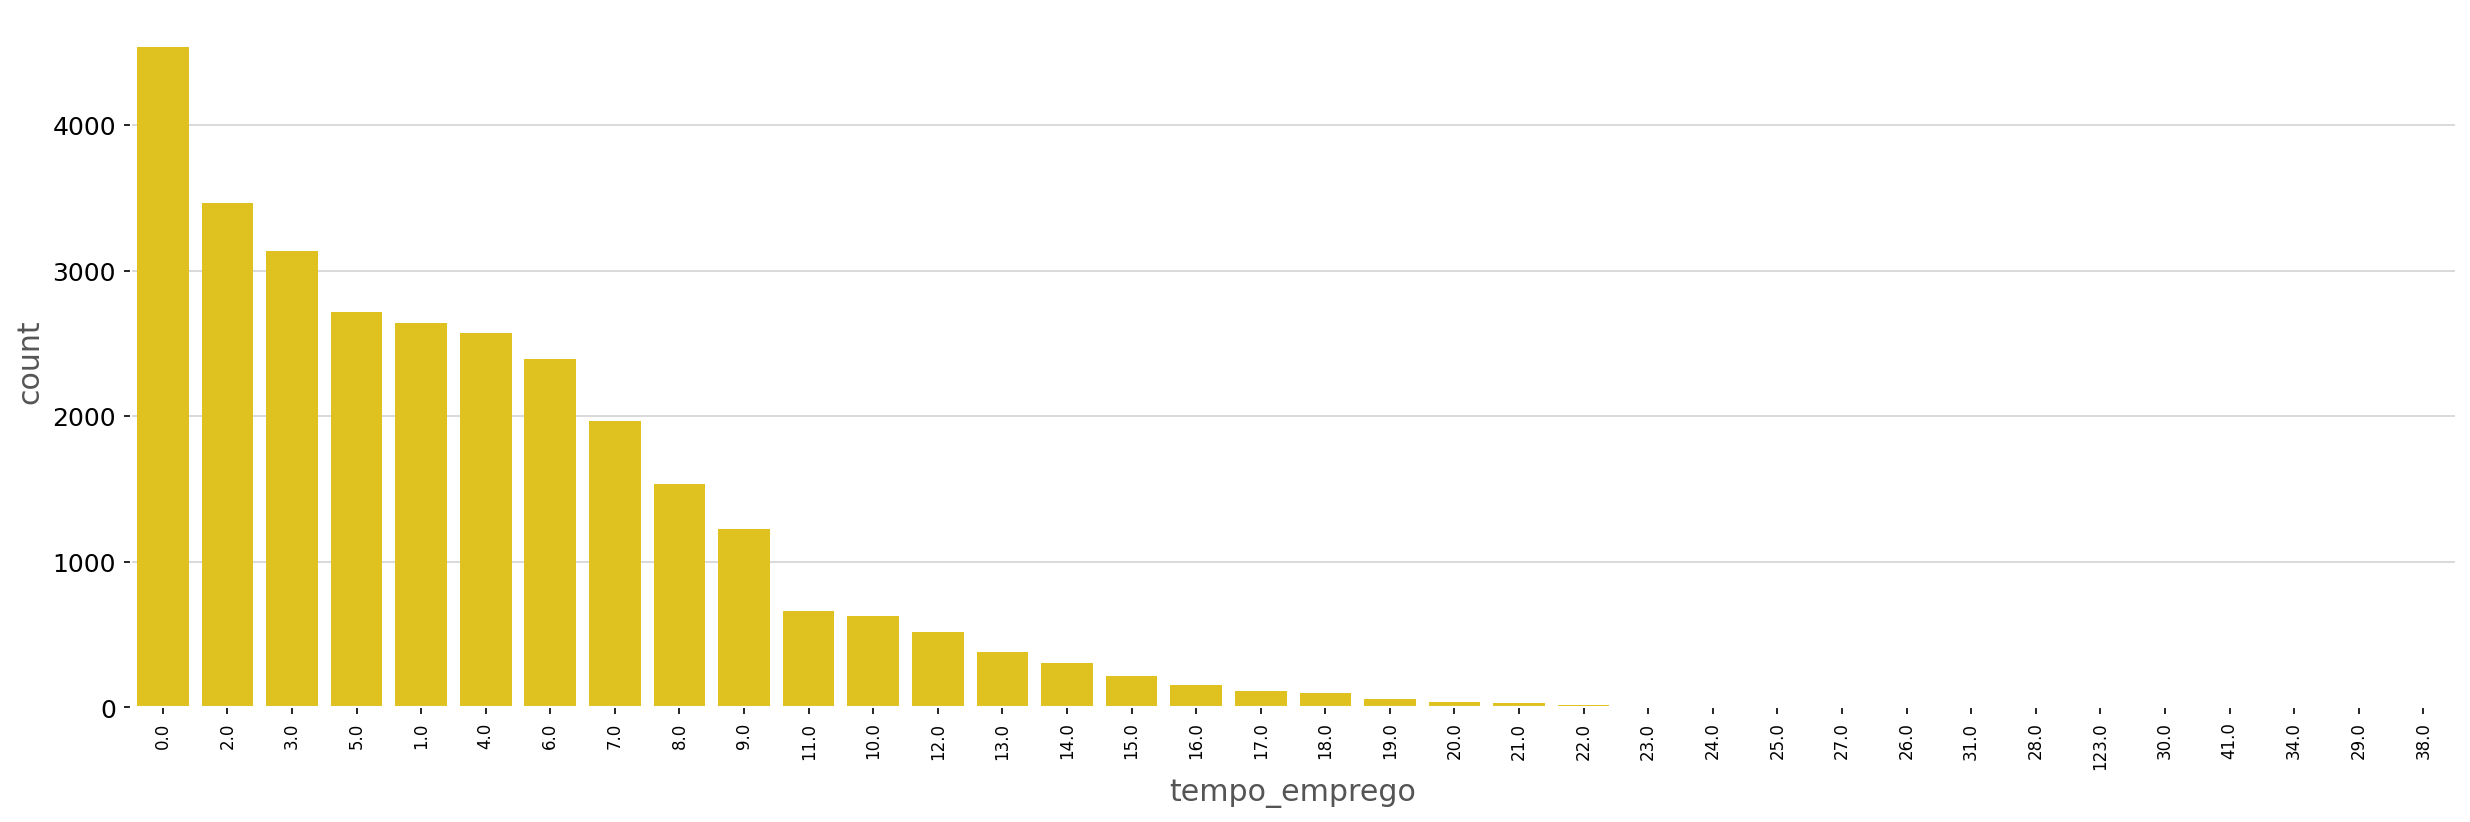

In [39]:
plt.figure(figsize=(20, 6))
sns.countplot(
    data=df_limpo,
    x="tempo_emprego",
    order=df_limpo["tempo_emprego"].value_counts().index
)
plt.xticks(rotation=90, fontsize=8)
plt.show()

### Tratando Outliers

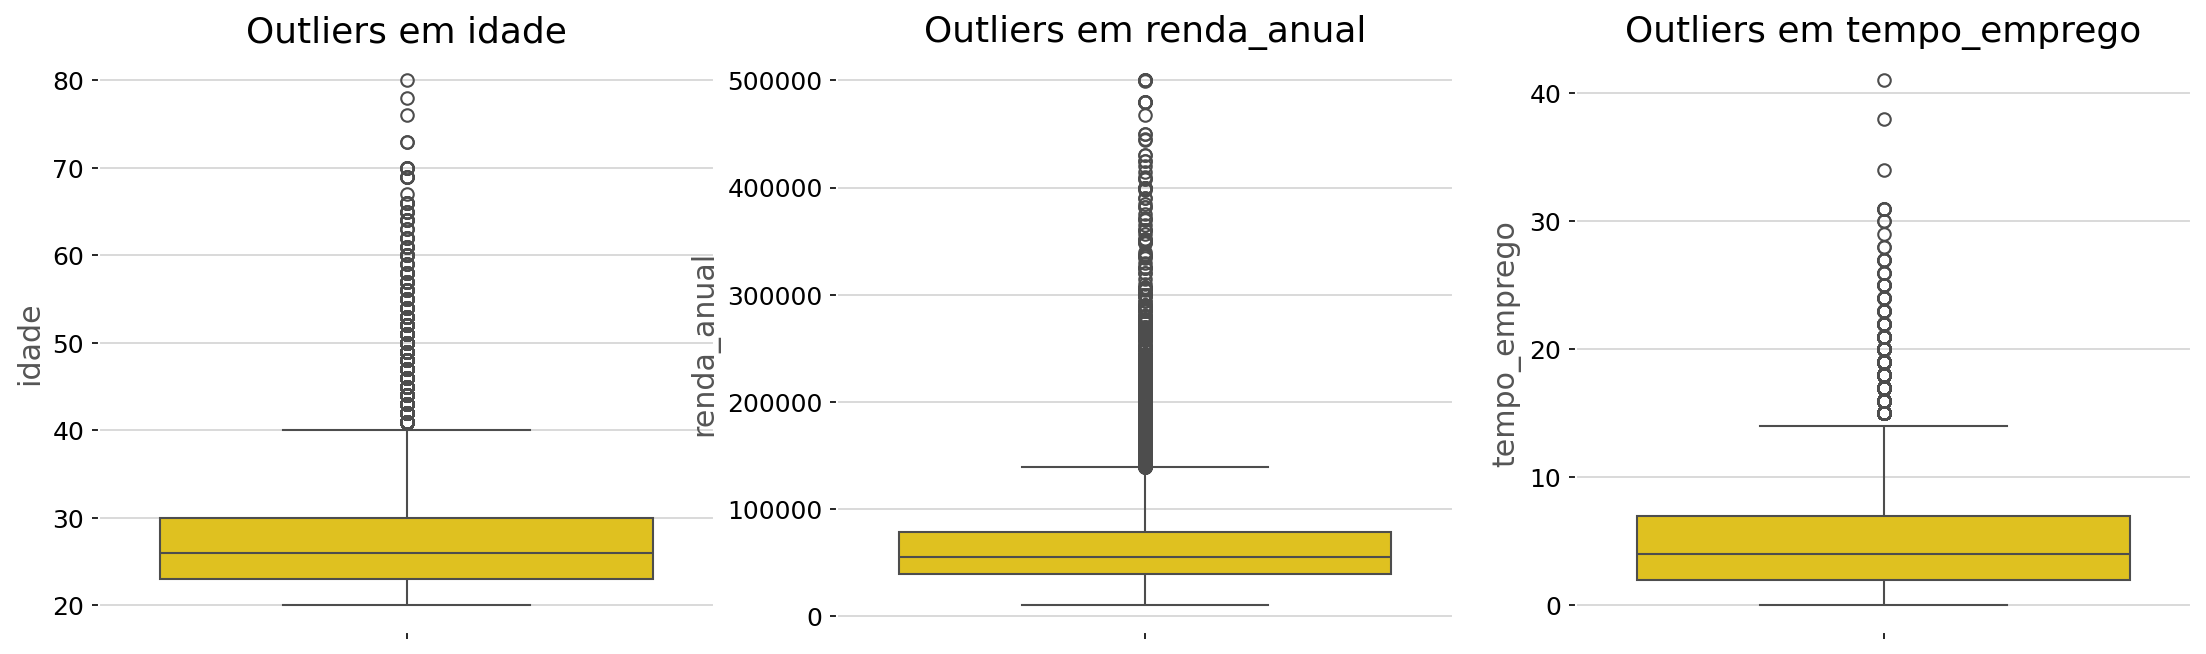

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(y=df_limpo['idade'], ax=axes[0])
axes[0].set_title('Outliers em idade')

sns.boxplot(y=df_limpo['renda_anual'], ax=axes[1])
axes[1].set_title('Outliers em renda_anual')

sns.boxplot(y=df_limpo['tempo_emprego'], ax=axes[2])
axes[2].set_title('Outliers em tempo_emprego')

plt.show()

- Definido range de **idade** que se tem interesse, pelo time de negócio. Idades entre 20 e 80 anos.
- Definido range de **renda_anual** que se tem interesse, pelo time de negócio. Valores entre: 10k e 500k.
- Definido range de **tempo_emprego** que se tem interesse, pelo time de negócio. Valores entre: 0 e 50 anos.

##### Tratativas: Regras de negócio definidas junto ao time de negócio e o PO do produto.

In [23]:
# Tratar outliers de person_age
df_limpo = tratar_outliers(df_limpo, 'idade', 20, 80)

In [51]:
# Tratar outliers de person_income
df_limpo = tratar_outliers(df_limpo, 'renda_anual', 10000, 500000)

In [52]:
# Tratar outliers de person_emp_length
df_limpo = tratar_outliers(df_limpo, 'tempo_emprego', 0, 50)

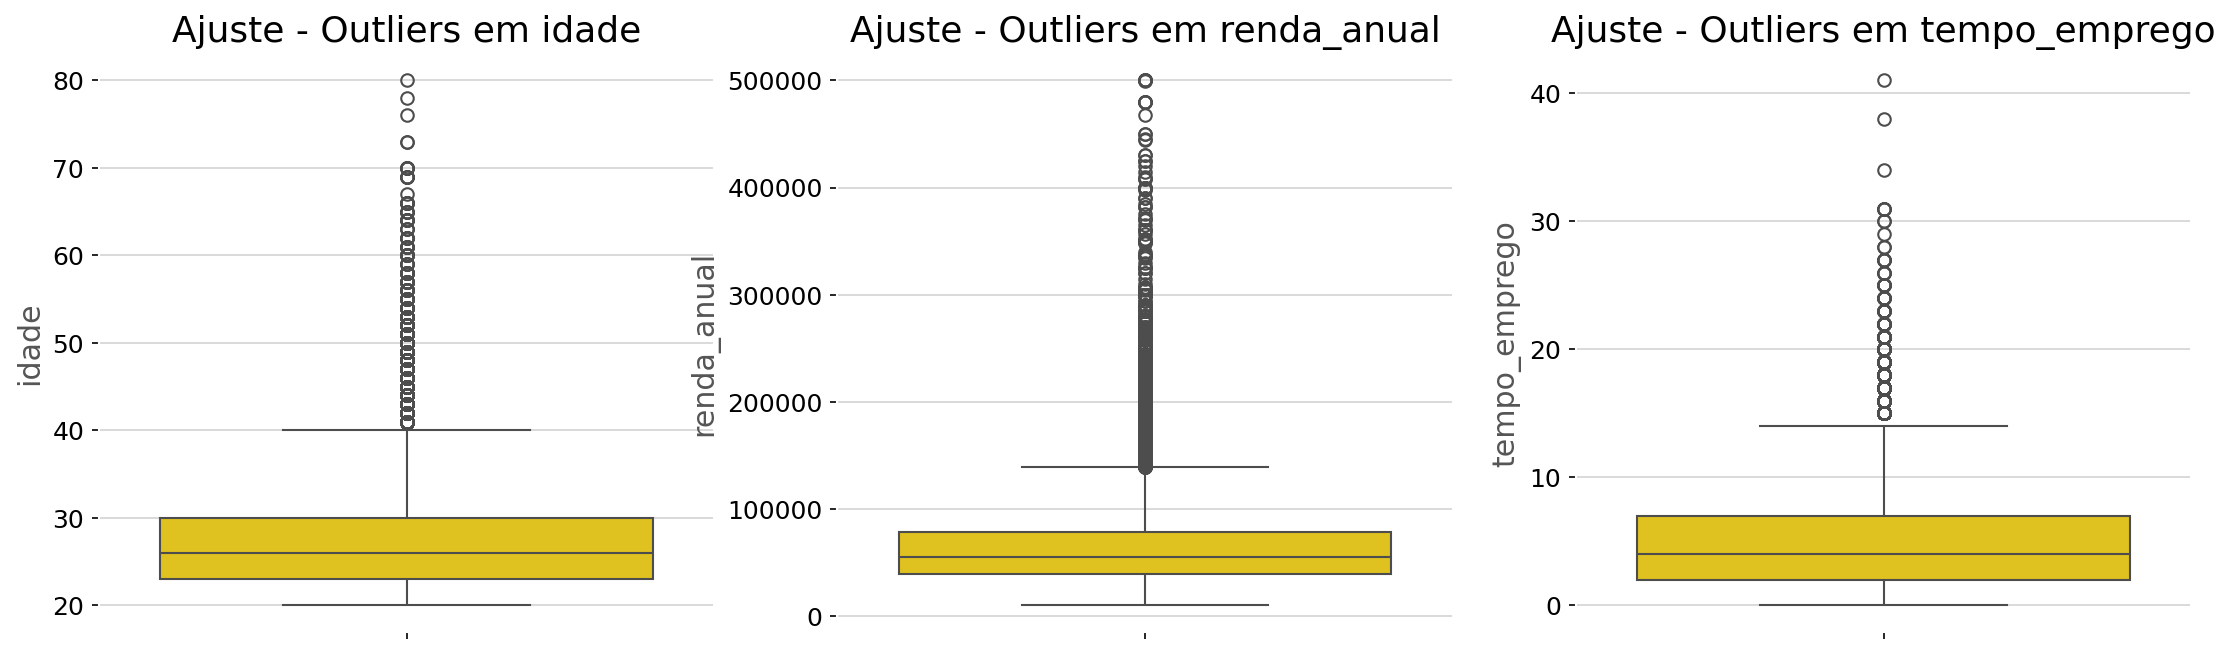

In [55]:
# Analise após tratamento dos outliers
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(y=df_limpo['idade'], ax=axes[0])
axes[0].set_title('Ajuste - Outliers em idade')

sns.boxplot(y=df_limpo['renda_anual'], ax=axes[1])
axes[1].set_title('Ajuste - Outliers em renda_anual')

sns.boxplot(y=df_limpo['tempo_emprego'], ax=axes[2])
axes[2].set_title('Ajuste - Outliers em tempo_emprego')

plt.show()

In [57]:
df_limpo.describe(include=["object"]).T

,count,unique,top,freq
tipo_residencia,29465,4,RENT,14893
objetivo_emprestimo,29465,6,EDUCATION,5854
cd_objetivo_emprestimo,29465,7,A,9774
target,29465,2,N,24252


# 3. Divide os Datasets em treino e teste
- Apenas 21.7% dos registros são de pessoas que vieram a inadimplência, isso pode causar um grande desbalanceamento na divisão dos dados de treino e de teste.
- Para contornar o desbalancemanto, é utilizado o <b>stratify=y</b> na função train_test_split, garantimos que a proporção seja mantida nos conjuntos de treino e teste.

In [ ]:
# Divide entre treino e teste
X = df_limpo.drop(columns=['target'])
y = df_limpo['target'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=27)

In [ ]:
# Visualiza o tamanho dos sets separados
print(f'O tamanho do dataset de treino é: {X_train.shape}')
print(f'O tamanho da target do treino é: {y_train.shape}')
print(f'O tamanho do dataset de teste é: {X_test.shape}')
print(f'O tamanho da target de teste é: {y_test.shape}')

O tamanho do dataset de treino é: (23572, 11)
O tamanho da target do treino é: (23572,)
O tamanho do dataset de teste é: (5893, 11)
O tamanho da target de teste é: (5893,)


In [ ]:
# Visualiza a proporção da variável target
print('Proporção da target de treino: ')
print(f'{y_train.value_counts(normalize=True)}')
print('Proporção da target de teste: ')
print(f'{y_test.value_counts(normalize=True)}')

Proporção da target de treino: 
target
N    0.823095
Y    0.176905
Name: proportion, dtype: float64
Proporção da target de teste: 
target
N    0.82301
Y    0.17699
Name: proportion, dtype: float64


# 4. Exploração de dados (EDA: exploratory data analysis)

In [ ]:
# Junta datasets de treino
df_analise = pd.concat([X_train, y_train], axis=1)
df_analise.head()

,idade,renda_anual,tipo_residencia,tempo_emprego,objetivo_emprestimo,cd_objetivo_emprestimo,valor_emprestimo,taxa_juros,estatus_inadimplencia,percentural_renda_consumido,anos_de_credito,target
7140,24.0,60000.0,RENT,8.0,EDUCATION,A,7000,7.51,1,0.12,4,N
21974,27.0,51000.0,MORTGAGE,0.0,EDUCATION,A,7000,7.49,0,0.14,6,N
17890,29.0,80000.0,RENT,2.0,MEDICAL,B,30000,12.42,1,0.38,9,N
2077,24.0,30000.0,MORTGAGE,9.0,DEBTCONSOLIDATION,C,2400,13.11,0,0.08,2,Y
12896,23.0,75000.0,RENT,2.0,PERSONAL,C,12000,12.98,0,0.16,2,Y


In [62]:
# Visualiza variáveis categóricas
for i in df_analise.describe(include=["object"]).columns:
    print(df_analise[i].value_counts())
    print("*" * 50)

tipo_residencia
RENT        11892
MORTGAGE     9707
OWN          1893
OTHER          80
Name: count, dtype: int64
**************************************************
objetivo_emprestimo
EDUCATION            4700
MEDICAL              4338
VENTURE              4111
PERSONAL             3990
DEBTCONSOLIDATION    3789
HOMEIMPROVEMENT      2644
Name: count, dtype: int64
**************************************************
cd_objetivo_emprestimo
A    7902
B    7410
C    4652
D    2670
E     716
F     170
G      52
Name: count, dtype: int64
**************************************************
target
N    19402
Y     4170
Name: count, dtype: int64
**************************************************


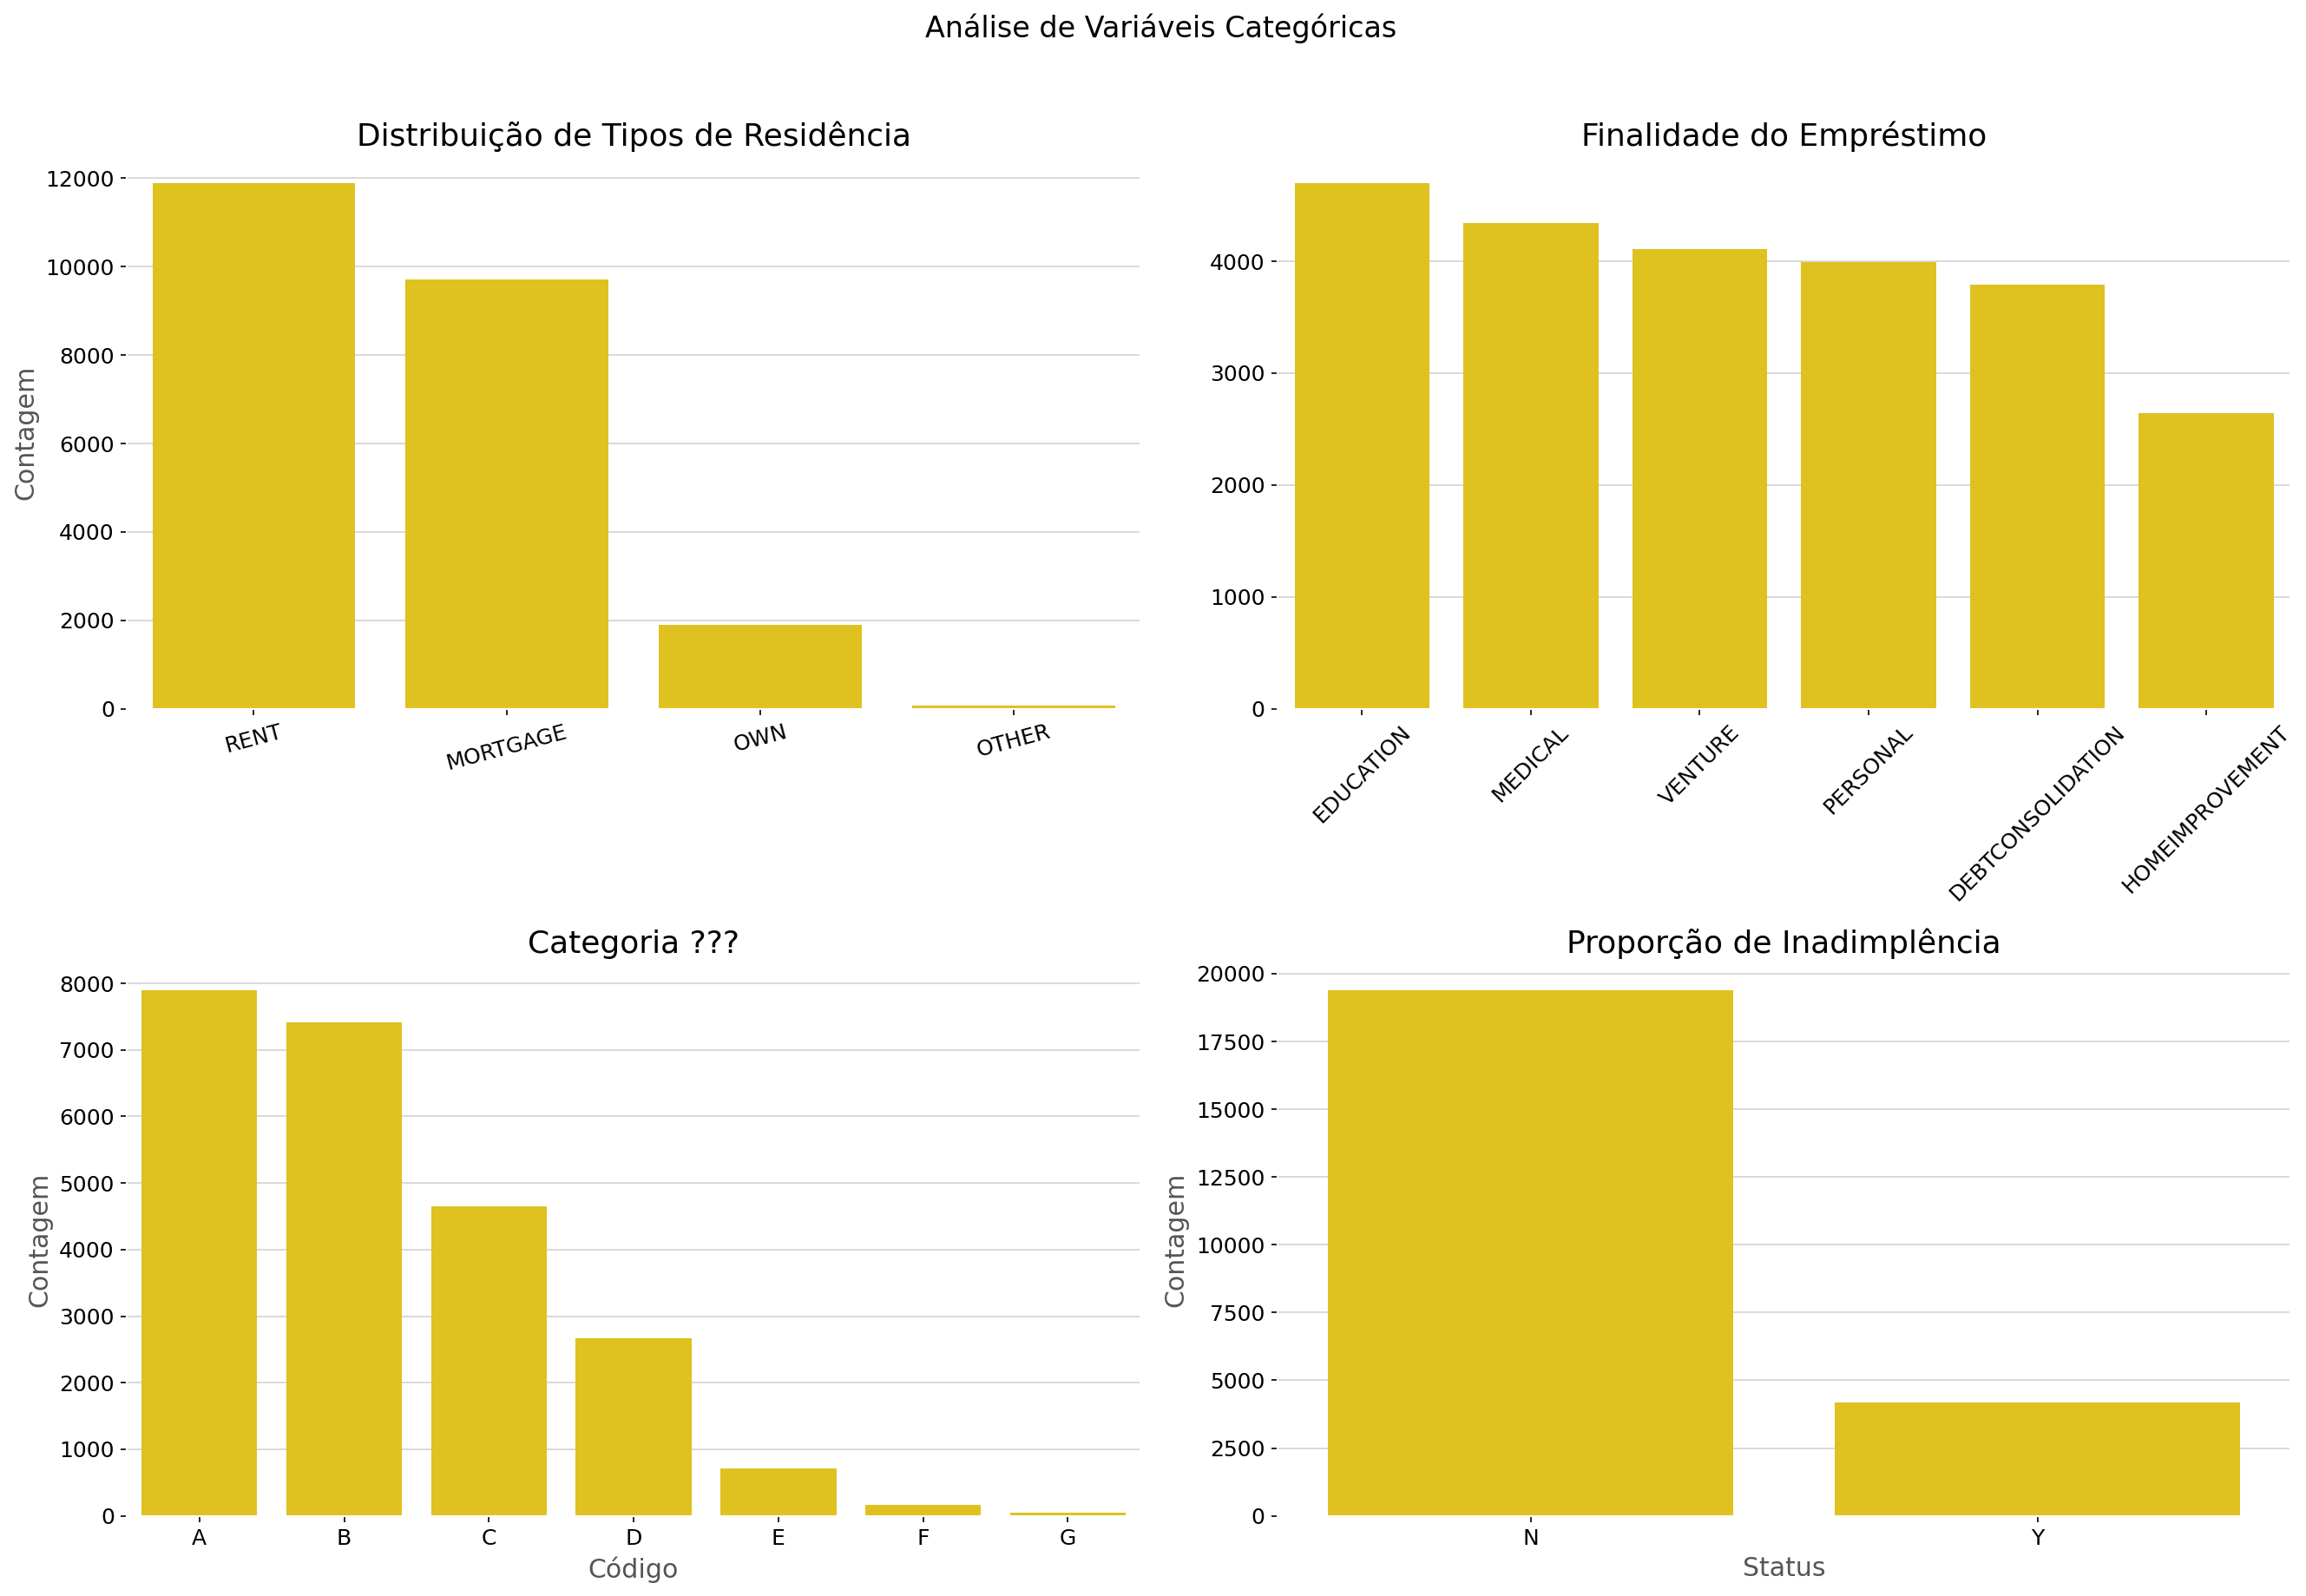

In [ ]:
# Plota todos os gráficos simples
plt.figure(figsize=(18, 12))
plt.suptitle('Análise de Variáveis Categóricas', fontsize=16, y=1.02)

# --- Gráfico 1: Tipo de Residência ---
plt.subplot(2, 2, 1)
sns.countplot(data=df_analise, 
              x='tipo_residencia', 
              order=df_analise['tipo_residencia'].value_counts().index)
plt.title('Distribuição de Tipos de Residência')
plt.xlabel('')
plt.ylabel('Contagem')
plt.xticks(rotation=45)

# --- Gráfico 2: Objetivo do Empréstimo ---
plt.subplot(2, 2, 2)
sns.countplot(data=df_analise, 
              x='objetivo_emprestimo', 
              order=df_analise['objetivo_emprestimo'].value_counts().index)
plt.title('Finalidade do Empréstimo')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45)

# --- Gráfico 3: Código do Objetivo ---
plt.subplot(2, 2, 3)
sns.countplot(data=df_analise, x='cd_objetivo_emprestimo', 
              order=df_analise['cd_objetivo_emprestimo'].value_counts().index)
plt.title('Categoria ???')
plt.xlabel('Código')
plt.ylabel('Contagem')

# --- Gráfico 4: Target (Inadimplência) ---
plt.subplot(2, 2, 4)
sns.countplot(data=df_analise, 
              x='target')
plt.title('Proporção de Inadimplência')
plt.xlabel('Status')
plt.ylabel('Contagem')

# Ajustes finais
plt.tight_layout()
plt.show()

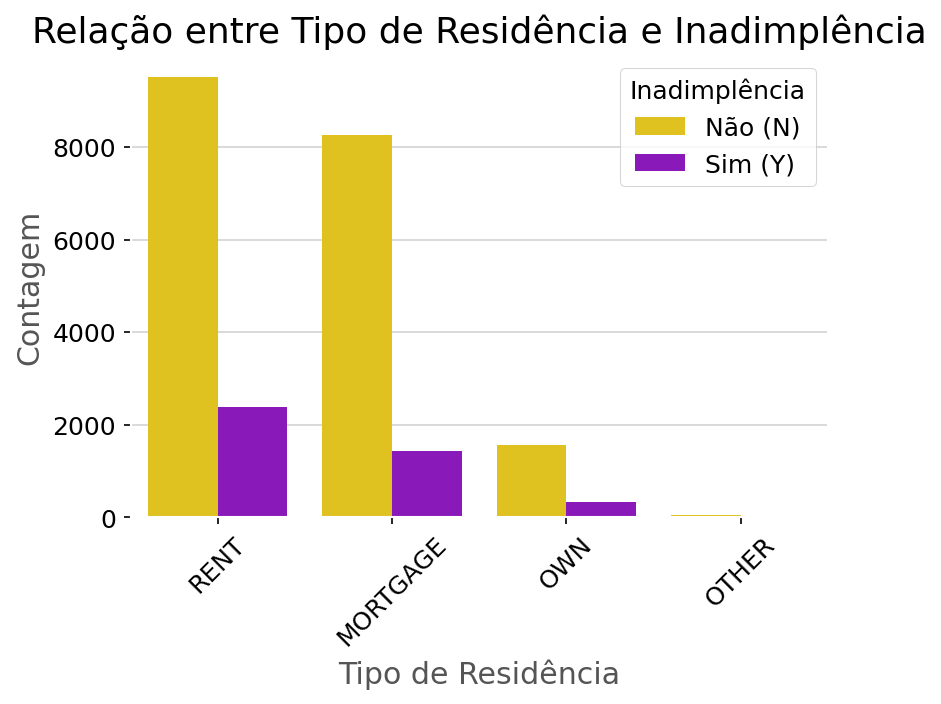

In [67]:
plt.figure(figsize=(6, 4))
sns.countplot(
    data=df_analise,
    x='tipo_residencia',
    hue='target',
    order=df_analise['tipo_residencia'].value_counts().index
)
plt.title('Relação entre Tipo de Residência e Inadimplência')
plt.xlabel('Tipo de Residência')
plt.ylabel('Contagem')
plt.legend(title='Inadimplência', labels=['Não (N)', 'Sim (Y)'])
plt.xticks(rotation=45)
plt.show()

C:\Users\vinic\AppData\Local\Temp\ipykernel_46020\3251092191.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)


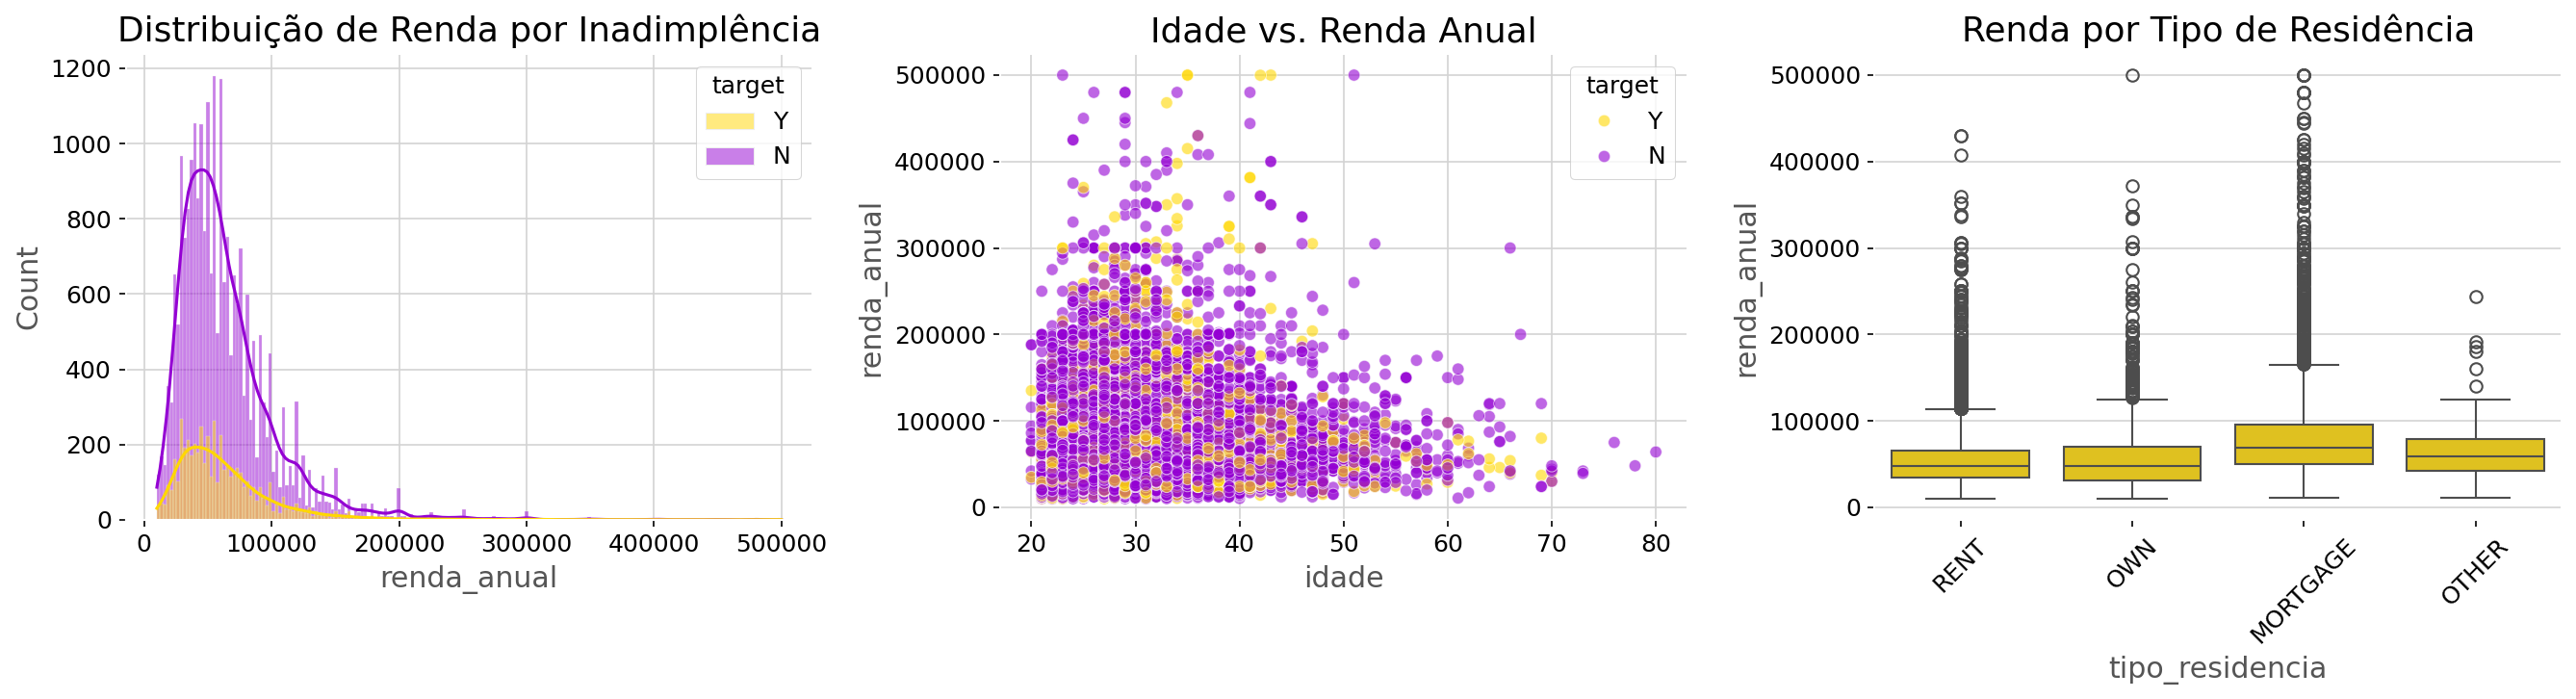

In [85]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Subplot 1
sns.histplot(data=df_limpo, x='renda_anual', kde=True, ax=ax1, hue='target')
ax1.set_title('Distribuição de Renda por Inadimplência')

# Subplot 2
sns.scatterplot(data=df_limpo, x='idade', y='renda_anual', hue='target', ax=ax2, alpha=0.6)
ax2.set_title('Idade vs. Renda Anual')

# Subplot 3
sns.boxplot(data=df_limpo, x='tipo_residencia', y='renda_anual', ax=ax3)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)
ax3.set_title('Renda por Tipo de Residência')

plt.tight_layout()
plt.show()